<h1><center><font size="6">Pretrained Models Notebook</font></center></h1>

# Contents

- <a href='#1'>Importing Packages</a>  
- <a href='#2'>ResNet50</a>
- <a href='#3'>AlexNet</a> 
- <a href='#4'>VGG19</a>    
    - <a href='#41'>Generating Datasets</a> 
    - <a href='#42'>Constructing and Compiling the Model</a> 
    - <a href='#43'>Defining Callbacks and Training the Model</a> 
    - <a href='#44'>Evaluating the Model</a> 
    - <a href='#45'>Predicting on Test Set</a>
    - <a href='#46'>Confusion Matrix</a> 
    - <a href='#47'>ROC-AUC and PR-AUC Curves</a>  


# Importing Packages

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm
import datetime
import itertools 
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG19

from sklearn import metrics
from sklearn.metrics import confusion_matrix, auc, roc_curve, precision_recall_curve

%reload_ext autoreload
%autoreload 2
from utils import *

# ResNet50

In [3]:
# Set path for trasining testing and validation
# Data Generator for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


In [4]:
# model creation
cnn_base = ResNet50(include_top = False,
                    weights = "imagenet",
                    input_shape = (256, 256, 3))
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 1, activation = 'sigmoid'))

cnn_base.trainable = False

In [5]:
# compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='PR')])

In [15]:
# define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
earlyStopping = EarlyStopping(monitor = 'val_loss', 
                              verbose = 1, 
                              mode = 'min', 
                              patience = 4)
filepath = "../logs/log_resnet/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
log_dir = "../logs/log_resnet/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')
csv_logger = CSVLogger('../logs/log_resnet/log.csv')

In [16]:
# train model
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = valid_generator,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = 20,
                             callbacks = [lr_reduction, earlyStopping, mcp_save, tensorboard_cb, csv_logger])

Epoch 1/20
427/427 [==============================] - 1818s 4s/step - loss: 0.5527 - accuracy: 0.7607 - precision: 0.7607 - recall: 1.0000 - auc: 0.4971 - auc_1: 0.7583 - val_loss: 0.4427 - val_accuracy: 0.8644 - val_precision: 0.8644 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.8644

Epoch 00001: saving model to ../logs/log_resnet/model.01-0.44.hdf5
Epoch 2/20
427/427 [==============================] - 1828s 4s/step - loss: 0.5519 - accuracy: 0.7610 - precision: 0.7610 - recall: 1.0000 - auc: 0.4917 - auc_1: 0.7617 - val_loss: 0.4295 - val_accuracy: 0.8644 - val_precision: 0.8644 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.8644

Epoch 00002: saving model to ../logs/log_resnet/model.02-0.43.hdf5
Epoch 3/20
427/427 [==============================] - 1933s 5s/step - loss: 0.5518 - accuracy: 0.7610 - precision: 0.7610 - recall: 1.0000 - auc: 0.4955 - auc_1: 0.7590 - val_loss: 0.4395 - val_accuracy: 0.8644 - val_precision: 0.8644 - val_recall: 1.0000 - val_auc: 0.5000 - 

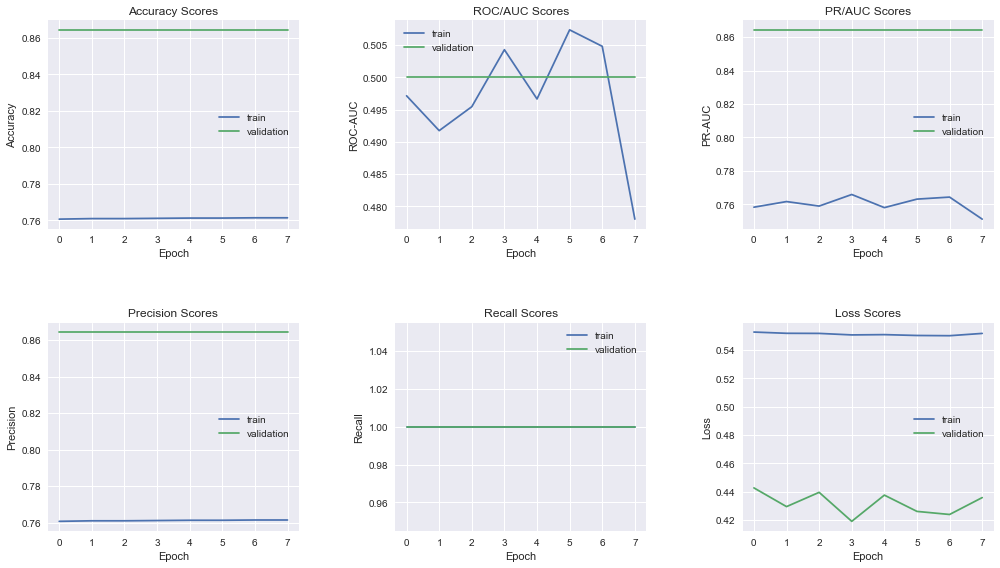

In [17]:
# visualization of the metrics tracked during training
plt.style.use('seaborn')
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [18]:
# display dataframe of the metrics per epoch
hist_df = pd.DataFrame(history.history)
hist_df

,loss,accuracy,precision,recall,auc,auc_1,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_auc_1,lr
0,0.552730,0.760698,0.760698,1.0,0.497142,0.758316,0.442683,0.864362,0.864362,1.0,0.5,0.864362,0.00100
1,0.551858,0.760991,0.760991,1.0,0.491740,0.761676,0.429458,0.864362,0.864362,1.0,0.5,0.864362,0.00100
2,0.551781,0.760991,0.760991,1.0,0.495453,0.758982,0.439537,0.864362,0.864362,1.0,0.5,0.864362,0.00100
3,0.550714,0.761137,0.761137,1.0,0.504290,0.765905,0.419065,0.864362,0.864362,1.0,0.5,0.864362,0.00100
4,0.550916,0.761284,0.761284,1.0,0.496651,0.758056,0.437575,0.864362,0.864362,1.0,0.5,0.864362,0.00050
5,0.550318,0.761284,0.761284,1.0,0.507367,0.763140,0.426081,0.864362,0.864362,1.0,0.5,0.864362,0.00050
6,0.550156,0.761430,0.761430,1.0,0.504817,0.764352,0.423906,0.864362,0.864362,1.0,0.5,0.864362,0.00050
7,0.551772,0.761430,0.761430,1.0,0.478015,0.751172,0.435827,0.864362,0.864362,1.0,0.5,0.864362,0.00025


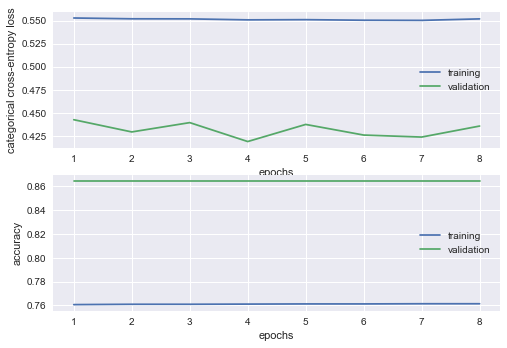

In [20]:
# visualize loss and accuracy
plt.style.use('seaborn')
train_val_metrics(8, history)

In [26]:
test_generator.reset()
pred = model.predict_generator(test_generator,
                               steps = STEP_SIZE_TEST,
                               verbose = 1)
y_true = test_generator.classes

753/753 [==============================] - 252s 334ms/step


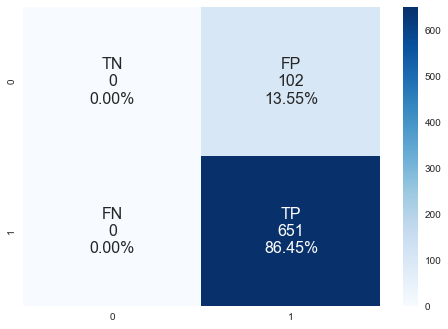

In [28]:
y_pred = pred > 0.5
make_confusion_matrix(y_true, y_pred)

In [34]:
# get testing loss and accuracy
X_test, y_test = next(test_generator)
score = model.evaluate(X_test, y_test, verbose = 1)
labels = model.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

1/1 [==============================] - 2s 2s/step - loss: 1.3920 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - auc_1: 0.0000e+00
loss: 1.392035961151123
accuracy: 0.0


# AlexNet



## Generate Datasets

In [37]:
# Set path for trasining testing and validation
# Data Generator for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (227, 227),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (227, 227),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (227, 227),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## Construct and Compile Model

In [38]:
# construct model
model2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model2.compile(loss = 'binary_crossentropy',
               optimizer = Adam(lr = 0.001),
               metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

## Define Callbacks and Train the Model

In [41]:
# define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
earlyStopping = EarlyStopping(monitor = 'val_loss', 
                              verbose = 1, 
                              mode = 'min', 
                              patience = 4)
filepath = "../logs/log_alexnet/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
log_dir = "../logs/log_alexnet/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')
csv_logger = CSVLogger('../logs/log_alexnet/log.csv')

In [42]:
# train model
history2 = model2.fit_generator(generator = train_generator,
                               steps_per_epoch = STEP_SIZE_TRAIN,
                               validation_data = valid_generator,
                               validation_steps = STEP_SIZE_VALID,
                               epochs = 20,
                               callbacks = [lr_reduction, earlyStopping, mcp_save, tensorboard_cb, csv_logger])

Epoch 1/20
427/427 [==============================] - 4282s 10s/step - loss: 7.8137 - accuracy: 0.8608 - precision_1: 0.9090 - recall_1: 0.9079 - auc_2: 0.8322 - auc_3: 0.9125 - val_loss: 0.3881 - val_accuracy: 0.9109 - val_precision_1: 0.9206 - val_recall_1: 0.9815 - val_auc_2: 0.8884 - val_auc_3: 0.9698

Epoch 00001: saving model to ../logs/log_alexnet/weights-improvement-01-0.39.hdf5
Epoch 2/20
427/427 [==============================] - 4929s 12s/step - loss: 0.6389 - accuracy: 0.8910 - precision_1: 0.9236 - recall_1: 0.9339 - auc_2: 0.9120 - auc_3: 0.9557 - val_loss: 0.2953 - val_accuracy: 0.9136 - val_precision_1: 0.9137 - val_recall_1: 0.9938 - val_auc_2: 0.9072 - val_auc_3: 0.9765

Epoch 00002: saving model to ../logs/log_alexnet/weights-improvement-02-0.30.hdf5
Epoch 3/20
427/427 [==============================] - 4970s 12s/step - loss: 0.4187 - accuracy: 0.8980 - precision_1: 0.9234 - recall_1: 0.9443 - auc_2: 0.9277 - auc_3: 0.9657 - val_loss: 0.3824 - val_accuracy: 0.9362 - 

## Evaluate Model

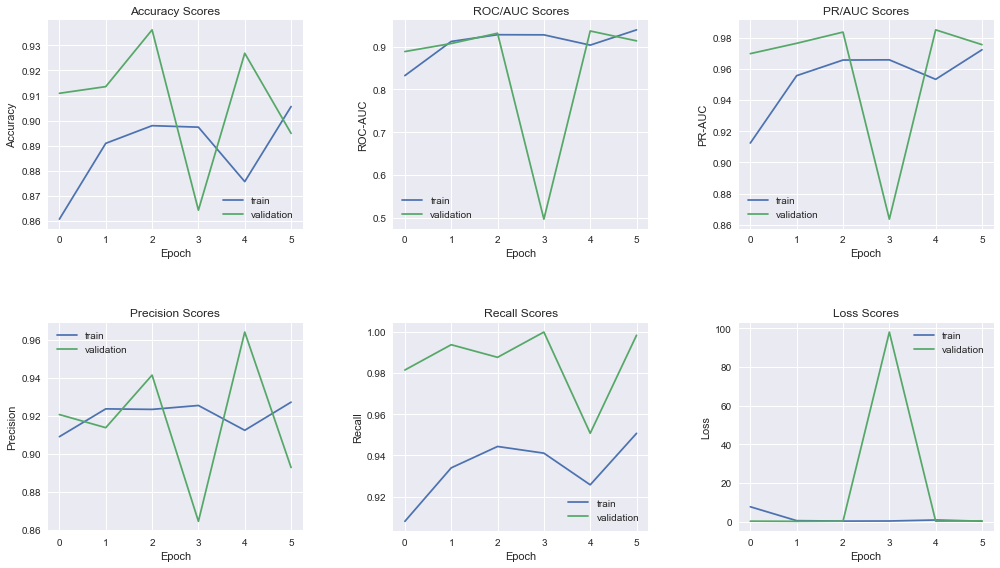

In [43]:
# visualize metrics measured
plt.style.use('seaborn')
sixplot(history2, 'auc_2', 'val_auc_2', 'auc_3', 'val_auc_3', 'precision_1', 'val_precision_1', 'recall_1', 'val_recall_1')

In [44]:
# display dataframe of metriccs
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,precision_1,recall_1,auc_2,auc_3,val_loss,val_accuracy,val_precision_1,val_recall_1,val_auc_2,val_auc_3,lr
0,7.813650,0.860785,0.908986,0.907935,0.832246,0.912480,0.388073,0.910904,0.920635,0.981538,0.888416,0.969848,0.001
1,0.638907,0.890973,0.923634,0.933950,0.912006,0.955711,0.295269,0.913564,0.913720,0.993846,0.907172,0.976474,0.001
2,0.418699,0.898007,0.923367,0.944348,0.927745,0.965739,0.382426,0.936170,0.941435,0.987711,0.931248,0.983664,0.001
3,0.464771,0.897421,0.925421,0.941097,0.927415,0.965859,98.079224,0.864362,0.864362,1.000000,0.496923,0.863639,0.001
4,0.985056,0.875733,0.912351,0.925698,0.903431,0.953363,0.383877,0.926862,0.964119,0.950769,0.936433,0.985103,0.001
5,0.366652,0.905627,0.927177,0.950731,0.939079,0.972340,0.544970,0.894947,0.892710,0.998462,0.913356,0.975612,0.001


## Predicting on Holdout Set

In [47]:
test_generator.reset()
prob2 = model2.predict_generator(test_generator,
                                 steps = STEP_SIZE_TEST,
                                 verbose = 1)

753/753 [==============================] - 116s 154ms/step


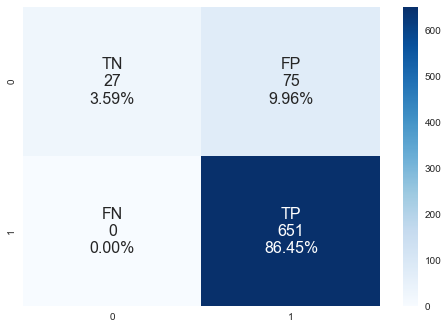

In [48]:
y_true = test_generator.classes
y_pred_2 = prob2 > 0.5
make_confusion_matrix(y_true, y_pred_2)

In [49]:
# get testing accuracy and loss
score = model2.evaluate_generator(test_generator, verbose = 1)
labels = model2.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

753/753 [==============================] - 106s 141ms/step - loss: 0.9815 - accuracy: 0.9004 - precision_1: 0.8967 - recall_1: 1.0000 - auc_2: 0.8769 - auc_3: 0.9658
loss: 0.9815390706062317
accuracy: 0.9003984332084656


## Save Model

In [50]:
model2.save('../models/alexnet')

INFO:tensorflow:Assets written to: ../models/alexnet/assets


# VGG19

## Generate Datasets

In [22]:
# generate datasets
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 10,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 10,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        class_mode = 'binary',
        batch_size = 753,
        seed = 42,
        shuffle = False)

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## Constructing and Compiling the Model

In [23]:
# construct model
vgg19 = VGG19(include_top = False, 
              weights = 'imagenet', 
              input_shape = (224, 224, 3))

model3 = models.Sequential()
model3.add(vgg19)
model3.add(layers.Flatten())
model3.add(layers.Dense(132, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

for layer in model3.layers:
    print(layer.name, layer.trainable)
    print(len(model.trainable_weights))

vgg19.trainable = False

for layer in model3.layers:
    print(layer.name, layer.trainable)
    print(len(model.trainable_weights))

# compile model
model3.compile(optimizer = Adam(lr=0.001),
               loss = 'binary_crossentropy',
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

vgg19 True
4
flatten_4 True
4
dense_7 True
4
dense_8 True
4
vgg19 False
4
flatten_4 True
4
dense_7 True
4
dense_8 True
4


## Defining Callbacks and Training the Model

In [24]:
# define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
# earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
mcp_save = ModelCheckpoint('../models/VGG19.h5', 
                           save_best_only=True, 
                           monitor='val_loss', 
                           mode='min')
tensorboard_cb = TensorBoard(log_dir="../logvgg19")
csv_logger = CSVLogger('../logvgg19/log.csv')

# train model
history3 = model3.fit(train_generator,
                     epochs = 20,
                     callbacks = [mcp_save, tensorboard_cb, csv_logger, lr_reduction],
                     validation_data = val_generator,
                     batch_size = 10)

Epoch 1/20
684/684 [==============================] - 2555s 4s/step - loss: 0.4027 - acc: 0.9057 - auc_6: 0.9095 - auc_7: 0.9494 - precision_3: 0.9296 - recall_3: 0.9454 - val_loss: 0.2255 - val_acc: 0.9256 - val_auc_6: 0.9456 - val_auc_7: 0.9884 - val_precision_3: 0.9700 - val_recall_3: 0.9432
Epoch 2/20
684/684 [==============================] - 1863s 3s/step - loss: 0.1558 - acc: 0.9512 - auc_6: 0.9681 - auc_7: 0.9832 - precision_3: 0.9550 - recall_3: 0.9821 - val_loss: 0.1815 - val_acc: 0.9376 - val_auc_6: 0.9544 - val_auc_7: 0.9890 - val_precision_3: 0.9428 - val_recall_3: 0.9877
Epoch 3/20
684/684 [==============================] - 1651s 2s/step - loss: 0.1193 - acc: 0.9586 - auc_6: 0.9818 - auc_7: 0.9927 - precision_3: 0.9602 - recall_3: 0.9869 - val_loss: 0.2088 - val_acc: 0.9256 - val_auc_6: 0.9623 - val_auc_7: 0.9907 - val_precision_3: 0.9775 - val_recall_3: 0.9355
Epoch 4/20
684/684 [==============================] - 1600s 2s/step - loss: 0.1150 - acc: 0.9586 - auc_6: 0.9824

## Evaluating the Model

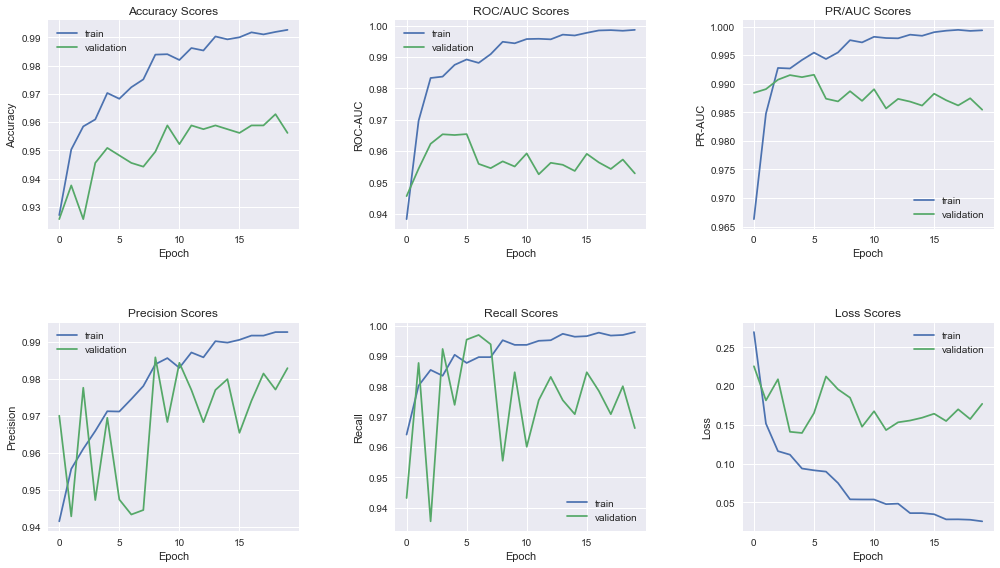

In [27]:
# evaluate model 
plt.style.use('seaborn')
sixplot(history3, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')

In [28]:
hist_df_3 = pd.DataFrame(history3.history)
hist_df_3

,loss,acc,auc_6,auc_7,precision_3,recall_3,val_loss,val_acc,val_auc_6,val_auc_7,val_precision_3,val_recall_3,lr
0,0.269627,0.927047,0.938315,0.966305,0.941474,0.964080,0.225523,0.925631,0.945649,0.988398,0.969984,0.943164,0.001000
1,0.151580,0.950292,0.969664,0.984754,0.955618,0.980215,0.181507,0.937583,0.954384,0.989048,0.942815,0.987711,0.001000
2,0.115991,0.958480,0.983305,0.992752,0.961034,0.985401,0.208755,0.925631,0.962328,0.990697,0.977528,0.935484,0.001000
3,0.111437,0.960965,0.983751,0.992659,0.965855,0.983481,0.140972,0.945551,0.965362,0.991503,0.947214,0.992320,0.001000
4,0.093593,0.970322,0.987496,0.994144,0.971181,0.990396,0.139445,0.950863,0.965129,0.991145,0.969419,0.973886,0.001000
5,0.091284,0.968275,0.989212,0.995435,0.971105,0.987706,0.165091,0.948207,0.965423,0.991560,0.947368,0.995392,0.001000
6,0.089581,0.972368,0.988120,0.994316,0.974466,0.989627,0.212341,0.945551,0.955927,0.987372,0.943314,0.996928,0.001000
7,0.074839,0.975146,0.990905,0.995469,0.977980,0.989627,0.195748,0.944223,0.954565,0.986899,0.944526,0.993856,0.001000
8,0.053829,0.983918,0.994855,0.997613,0.983859,0.995198,0.184981,0.949535,0.956733,0.988683,0.985737,0.955453,0.000500
9,0.053655,0.984064,0.994368,0.997220,0.985521,0.993661,0.147498,0.958831,0.955092,0.986995,0.968278,0.984639,0.000500


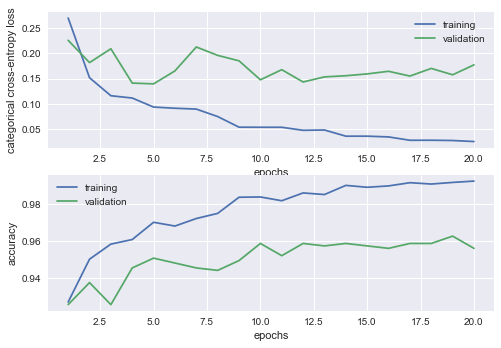

In [31]:
plt.style.use('seaborn')
train_val_metrics(20, history3)

## Predicting on Test Set

In [33]:
X_tt, y_tt = next(test_generator)
score = model3.evaluate(X_tt, y_tt, verbose = 1)
labels = model3.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

24/24 [==============================] - 102s 4s/step - loss: 0.1677 - acc: 0.9482 - auc_6: 0.9490 - auc_7: 0.9858 - precision_3: 0.9722 - recall_3: 0.9677
loss: 0.16768935322761536
acc: 0.9482071995735168


## Confusion Matrix

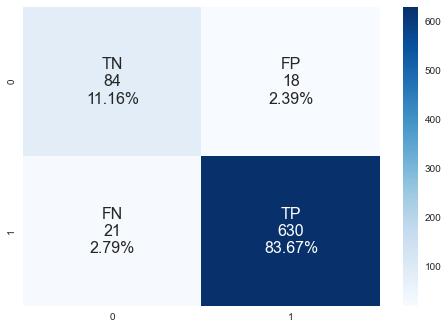

In [32]:
prob3 = model3.predict_generator(test_generator)
y_true = test_generator.classes
y_pred3 = prob3 > 0.5
make_confusion_matrix(y_true, y_pred3)

## ROC-AUC and PR-AUC Curves

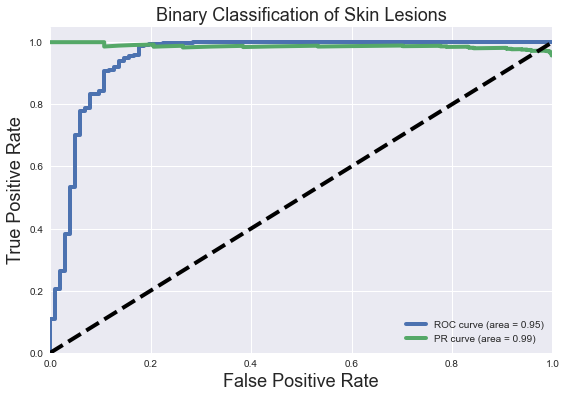

In [36]:
y_score = model3.predict_proba(X_tt)
fpr, tpr, __ = roc_curve(y_tt, y_score)
roc_auc = auc(fpr, tpr)
prec,rec, __ = precision_recall_curve(y_tt, y_score)
pr_auc = auc(rec, prec)

plt.figure(figsize = [9, 6])
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc, linewidth = 4)
plt.plot(rec, prec, label = 'PR curve (area = %0.2f)' % pr_auc, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth = 4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Binary Classification of Skin Lesions', fontsize = 18)
plt.legend(loc = 'lower right')
plt.show()